NOTE: Much of this code was taken from this reference solution: https://david-salazar.github.io/dilettanting-deep-learning/2020/06/23/Fastbook-Chapter-4.html. The intended purpose is to document where it differs from my solution to faciliate learning.

In [57]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/paperspace/.fastai/data/mnist_png/testing'),Path('/home/paperspace/.fastai/data/mnist_png/training')]

First, use the idiomatic `DataBlock` API to load data instead of manually loading from disk as I did. As per chapter 2, there are at least four things I need to provide:
- What kinds of data we are working with
    - ImageData with a CategoryBlock
- How to get the list of items
    - Use the get_image_files function
- How to label these items
    - Use the fastai provided `parent_label` function, which uses the name of the folder
- How to create the validation set
    - This was a new one: `GrandparentSplitter(train_name='training', valid_name='testing')`

In [59]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                  get_y=parent_label)

As per chapter 2 again, this is just a template.

To have live "dataloaders", we must provide the path we used above.

In [60]:
dls = mnist.dataloaders(path)

The nice thing about using the fastai data loaders is we can use pre-built methods for seeing the results.

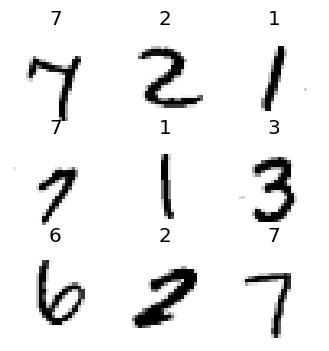

In [61]:
dls.show_batch(max_n=9, figsize=(4,4))

Apparently `Flatten` be passed into the model, avoiding the need to do separate preprocessing.

In [62]:
simple_net = nn.Sequential(
    Flatten(),
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 10),
)

In [ ]:
mnist_learner = Learner(dls, simple_net.to(device), opt_func=SGD, 
                        loss_func=F.cross_entropy, metrics=accuracy)
mnist_learner.fit(40)

epoch,train_loss,valid_loss,accuracy,time
0,2.189835,2.184307,0.373200,00:45
1,2.020317,2.002742,0.488800,00:46
2,1.776634,1.755157,0.579000,00:45
3,1.504731,1.476359,0.701800,00:46
4,1.241272,1.214747,0.777100,00:45
5,1.043819,1.012798,0.805300,00:46
6,0.899319,0.869988,0.822600,00:46
7,0.789805,0.768641,0.834700,00:47
8,0.710833,0.695063,0.845300,00:46
9,0.661542,0.638964,0.852800,00:45


Similar results - tops out in the low 90s

Two things to learn here (practice looking things up in the docs):
1. What is `F.cross_entropy` and how does it differ from my `mnist_loss` in the other notebook?
2. What is Pytorch/FastAI's inbuilt `accuracy`? 

1. `F.cross_entropy`

Apparently it: "Compute the cross entropy loss between input logits and target."
    
Logits are the models raw predictions, pre-sigmoid. So, it is appropriate to not take the Sigmoid in the model, even though it's possible to. Better to keep the model's predictions what they are, and then if there's a computation that needs to be added for loss purposes, that can be done.

But what is the Cross Entropy Loss?

Pytorch docs have a bunch of scary math, but says: "It is useful when training a classification problem with C classes.". OK, that's us! 

More specifically, it: "takes the negative logarithm of the predicted probability for the true class." (Google). 

-log(0.1) >> -log(0.9), which is what we want (higher loss for lower prediction of the true class). 

2. `accuracy`

The docs don't give much of an explanation, but we can easily verify whether this works on a sample of data we'd realistically pass to our model. 

In [ ]:
preds = tensor([
    [9, 1, 2],
    [1, 7, 4],
    [3, 2, 8]
])

actuals = tensor([
    [1, 0, 0], # right
    [1, 0, 0], # right
    [0, 1, 0]  # wrong
])

# NOTE: accuracy expects indices of correct answer for target
accuracy(preds, actuals.argmax(dim=1))  # should be 0.333

Good!